# Exploring climate data 

## Retriving data with CEDA:

* Ceda stuff here

## Overview


* Using [Iris](https://scitools-iris.readthedocs.io/en/stable/) to explore UKCP data 


## Prerequisites 
To successfully navigate this notebook, you should be accustom with:
* Basics of python programming:
    * loading modules 
    * variable assignment 
    * basic plotting packages (`Matplotlib.pyplot`)
* Have a basic understanding of weather and climate, for example:
    * Latitude is North-South
    * Longitude is East-West
* Not a full requirement but you may find this notebook useful after or alongside "Exploring_gridded_data_with_iris.ipynb"

## Learning outcomes

* Calulate useful statistics from Climate data
* Make simple summary plots for example:
    * Time series 
    * BoxPlots 
    
## BackGround 

* UKCP ([UK Climate Projections](https://www.metoffice.gov.uk/research/approach/collaboration/ukcp/about)) provides probabilistic projections over land and a set of high-resolution spatially-coherent future climate projections for the globe at 60km scale, also over the UK at:
    * 12km scale 
    * 2.2km scale - a level previously only used for short-term weather forecasts
    
* [Iris](https://scitools-iris.readthedocs.io/en/stable/) is a Python module, produced by the Met Office to allow easy access to Geospatial Data 
* Iris functions well with well known modules like `Matplotlib` and `Numpy`
* Iris stores data in Cubes- representing the dimensions of the earth:
    * Latitude
    * Longitude
    * Time
* These cubes can be analysed in different dimensions to extract relevant information


First lets import the modules we will be using



In [1]:
import iris
import numpy as np
import pandas as pd
import iris.quickplot as qplt
import iris.plot as iplt
import matplotlib.pyplot as plt

/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Now lets define our filename and load he data into an iris cube using `iris.load_cube()`

* `iris.load_cube` works when you are only expecting one cube from a file, so loads directly to a cube instead of a cube list

In [2]:
filename = '/data/users/ncreaser/CEDA/tas_rcp85_land-cpm_uk_2.2km_01_day_19811201-19821130.nc'

In [3]:
cube = iris.load_cube(filename)

Print our cube and read our metadata

In [4]:
cube

Air Temperature (degC),ensemble_member,time,grid_latitude,grid_longitude
Shape,1,360,606,484
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
grid_latitude,-,-,x,-
grid_longitude,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


#### Looking at the printout of our cube:

* ensemble member 1 
* 360 timestamps
* latitude and longitudes

#### Lets plot a map

* Lets quickly plot a map of our data
* Since we have an ensemble member in our data, we need to index this and time

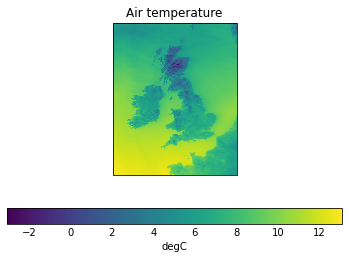

In [5]:
qplt.pcolormesh(cube[0,0,:,:])

#### Have a look at the time cooridnate

In [6]:
print(cube.coord('time').cell(0))
print(cube.coord('time').cell(-1))

Cell(point=cftime.Datetime360Day(1981, 12, 1, 12, 0, 0, 0, has_year_zero=True), bound=(cftime.Datetime360Day(1981, 12, 1, 0, 0, 0, 0, has_year_zero=True), cftime.Datetime360Day(1981, 12, 2, 0, 0, 0, 0, has_year_zero=True)))
Cell(point=cftime.Datetime360Day(1982, 11, 30, 12, 0, 0, 0, has_year_zero=True), bound=(cftime.Datetime360Day(1982, 11, 30, 0, 0, 0, 0, has_year_zero=True), cftime.Datetime360Day(1982, 12, 1, 0, 0, 0, 0, has_year_zero=True)))


### Plotting the mean and standard deviation over time

* collapsed can be used to collapse a cube over certain coordinates
* collapsing latitude and longitude by taking the mean of their value gives us a time series of means

In [7]:
mean = cube.collapsed((['grid_latitude', 'grid_longitude']), iris.analysis.MEAN)
std = cube.collapsed((['grid_latitude', 'grid_longitude']), iris.analysis.STD_DEV)

/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'grid_latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/iris/coords.py:1976: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/iris/coords.py:1976: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/iris/coords.py:1976: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/h06/ncreaser/.conda

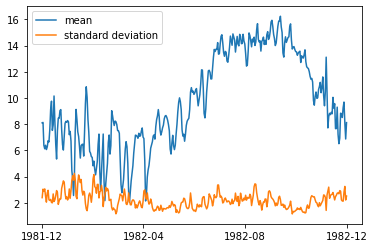

In [8]:
iplt.plot(mean[0], label='mean')
iplt.plot(std[0],label='standard deviation')
plt.legend()

* check what units we are using

In [9]:
cube.metadata.units

Unit('degC')

### Area weighted collapse 

since grid_latitude and grid_longitude boxes are not equal in size, we can take a area weighted mean, which takes into account the size of the grid box. Here's how you do it

In [10]:
import iris.analysis.cartography

In [11]:
grid_areas = iris.analysis.cartography.area_weights(cube)

ValueError: Calling `_get_lon_lat_coords` with multiple lat or lon coords is currently disallowed

* looks like the latitude and longitude scalar coordinates could be stopping this
* lets try remove them first

In [12]:
cube.remove_coord('latitude')
cube.remove_coord('longitude')

In [13]:
cube

Air Temperature (degC),ensemble_member,time,grid_latitude,grid_longitude
Shape,1,360,606,484
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
grid_latitude,-,-,x,-
grid_longitude,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


In [14]:
grid_areas = iris.analysis.cartography.area_weights(cube)

* great that worked! 
* for the command above to work both `grid_latitude` and `grid_longitude` need to have bounds 
* if you find a situation where a cube doesn't have bounds, you  can run a command to guess them 
* for example 

`cube.coord('grid_latitude').guess_bounds()`

`cube.coord('grid_longitude').guess_bounds()`

* now lets calculate our weighted mean

In [15]:
mean_weighted = cube.collapsed((['grid_latitude', 'grid_longitude']), iris.analysis.MEAN, weights=grid_areas)

* lets compare mean and mean_weighted

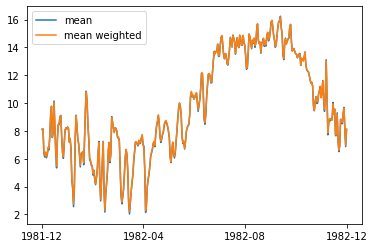

In [16]:
iplt.plot(mean[0], label='mean')
iplt.plot(mean_weighted[0],label='mean weighted')
plt.legend()

Can see a slight difference with the blue under the orange

### Summary of statistics

* None of this cubes data is masked, we can see this by printing `cube.data.mask`
* To get the data out we only need to do a `.data.data`
* Can then put into a pandas dataframe and get a summary of statistics

In [17]:
cube.data.mask

False

In [18]:
data = cube.data.data

In [19]:
data.shape

(1, 360, 606, 484)

In [20]:
df = pd.DataFrame(data.ravel(),columns = ['air_temp_values'])
df.describe()

,air_temp_values
count,1.055894e+08
mean,9.704495e+00
std,4.249174e+00
min,-1.848618e+01
25%,6.733057e+00
50%,9.660303e+00
75%,1.286660e+01
max,2.889956e+01


* The way above easy enough and works well
* However if we have to much data we will get memory issues
* Here's a function to return a summary of statistics collapsing with iris
* this should keep data lazy and not load into memory

    
 

In [21]:
def iris_describe(cube,weights=None):
    
    coords = [coord.name() for coord in cube.dim_coords]
    count = cube.collapsed((coords), iris.analysis.COUNT,function=lambda values: values != np.NaN)
    mean = cube.collapsed((coords), iris.analysis.MEAN,weights=weights)
    std = cube.collapsed((coords), iris.analysis.STD_DEV)
    mini = cube.collapsed((coords), iris.analysis.MIN)
    maxi = cube.collapsed((coords), iris.analysis.MAX)
    
    dictionary = {
        'count':count.data,
        'mean': mean.data,
        'std':std.data,
        'min':mini.data,
        'max':maxi.data,
    }
    
    return dictionary


In [22]:
dictonary = iris_describe(cube)

/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self.name()))
/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month_number'.
  warnings.warn(msg.format(self.name()))
/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))
/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self

#### Print the dictonary values we collected 

* We can see a summary of the statistics we collected here
* Have a go at changing/ writing a new function that uses different statistics, click [here](https://scitools-iris.readthedocs.io/en/stable/generated/api/iris/analysis.html#module-iris.analysis) for more info on statistics provided by `iris.analysis`

In [23]:
dictonary

{'count': array(105589440),
 'mean': array(9.704495, dtype=float32),
 'std': array(4.2491746, dtype=float32),
 'min': array(-18.486181, dtype=float32),
 'max': array(28.89956, dtype=float32)}

* While we have our data in a pandas dataframe, lets plot a boxplot to visulaise our statistics

<AxesSubplot:>

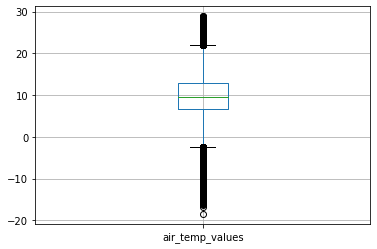

In [24]:
df.boxplot()